<a href="https://colab.research.google.com/github/mkirby1995/DS-Unit-2-Sprint-4-Practicing-Understanding/blob/master/DS_Unit_2_Sprint_Challenge_4_Practicing_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science Unit 2_
 
 # Sprint Challenge: Practicing & Understanding Predictive Modeling

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) **Use cross-validation** to **do hyperparameter optimization**, and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

_To earn a score of 3 for this part, make at least two of these visualization types._

### Part 4: Gradient Descent

Answer both of these two questions:

- What does Gradient Descent seek to minimize?
- What is the "Learning Rate" and what is its function?

One sentence is sufficient for each.

_To earn a score of 3 for this part, go above and beyond. Show depth of understanding and mastery of intuition in your answers._

# Part 1: Find Leaky Feature

In [2]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [0]:
X_train = train.drop(columns=('Fail'))
y_train = train['Fail']

X_test = test.drop(columns=('Fail'))
y_test = test['Fail']

In [4]:
X_train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':..."
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'..."
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'..."
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'..."
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN


In [5]:
y_train.head()

0    1
1    0
2    0
3    0
4    0
Name: Fail, dtype: int64

In [6]:
!pip install category_encoders

     |████████████████████████████████| 92kB 3.5MB/s 


In [0]:
import category_encoders as ce
from category_encoders.ordinal import OrdinalEncoder

def clean():
  X_train['Risk'] = X_train['Risk'].fillna('Risk 1 (High)')
  X_test['Risk'] = X_test['Risk'].fillna('Risk 1 (High)')
  
  X_train['Inspection Type'] = X_train['Inspection Type'].fillna('Canvass')
  X_test['Inspection Type'] = X_test['Inspection Type'].fillna('Canvass')
  
  X_train['Violations'] = X_train['Violations'].fillna('none')
  X_test['Violations'] = X_test['Violations'].fillna('none')
  
  X_train['Inspection Date'] = pd.to_datetime(X_train['Inspection Date'])
  X_test['Inspection Date'] = pd.to_datetime(X_test['Inspection Date'])
  
  X_train['Facility Type'] = X_train['Facility Type'].fillna('other')
  X_test['Facility Type'] = X_test['Facility Type'].fillna('other')
  
  X_train['Risk'] = X_train['Risk'].replace({'Risk 1 (High)': 3, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':1})
  X_test['Risk'] = X_test['Risk'].replace({'Risk 1 (High)': 3, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':1})
  
  X_train['Violations'] = OrdinalEncoder().fit_transform(X_train['Violations'])
  X_test['Violations'] = OrdinalEncoder().fit_transform(X_test['Violations'])
  
  X_train['Facility Type'] = OrdinalEncoder().fit_transform(X_train['Facility Type'])
  X_test['Facility Type'] = OrdinalEncoder().fit_transform(X_test['Facility Type'])
  

In [0]:
clean()

In [0]:
Ins_type = ce.OneHotEncoder(use_cat_names=True).fit_transform(X_train['Inspection Type'])
X_train = X_train.merge(Ins_type, on = X_train.index)
X_train = X_train.drop(columns='Inspection Type')

Ins_type_ = ce.OneHotEncoder(use_cat_names=True).fit_transform(X_test['Inspection Type'])
X_test = X_test.merge(Ins_type_, on = X_test.index)
X_test = X_test.drop(columns='Inspection Type')

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51916 entries, 0 to 51915
Data columns (total 67 columns):
key_0                                                     51916 non-null int64
Inspection ID                                             51916 non-null int64
DBA Name                                                  51916 non-null object
AKA Name                                                  51293 non-null object
License #                                                 51911 non-null float64
Facility Type                                             51916 non-null int64
Risk                                                      51916 non-null int64
Address                                                   51916 non-null object
City                                                      51863 non-null object
State                                                     51906 non-null object
Zip                                                       51890 non-null float64
Inspection Da

In [0]:
X_train['Latitude'] = X_train['Latitude'].fillna(0)
X_train['Longitude'] = X_train['Longitude'].fillna(0)

X_test['Latitude'] = X_test['Latitude'].fillna(0)
X_test['Longitude'] = X_test['Longitude'].fillna(0)

In [0]:
X_train = X_train.drop(columns=['DBA Name', 'AKA Name', 'Address', 'City', 'State', 'Location', 'Inspection Date', 'License #', 'Zip', 'key_0'])

## Baseline Model

In [14]:
majority_class = y_train.mode()[0]
majority_class_prediction = [majority_class] * len(y_train)

from sklearn.metrics import accuracy_score

accuracy_score(y_train, majority_class_prediction)

0.741389937591494

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

In [16]:
y_train.value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

Leaky Feature = Violations

Leakage is when a feature contains information that would only be known if the label was known...no time traveling

# Part 2: Model

## Decision Stump

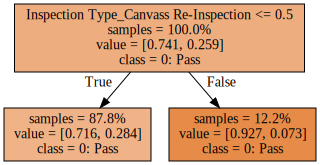

In [17]:
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz

tree = DecisionTreeClassifier(max_depth=1)

tree.fit(X_train, y_train)

dot_data = export_graphviz(tree, out_file=None, feature_names=X_train.columns, 
                           class_names=['0: Pass', '1: Fail'], filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

In [18]:
tree_probabilities = tree.predict_proba(X_train)
tree_probabilities = pd.DataFrame(tree_probabilities)
#tree_probabilities
roc_auc_score(y_train, tree_probabilities[0])

0.4408704476607763

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


def model_analysis(model, train_X, train_y, model_name):
  model_probabilities = model.predict_proba(train_X)

  Model_Prediction_Probability = []

  for _ in range(len(train_X)):
    x = max(model_probabilities[_])
    Model_Prediction_Probability.append(x)

  plt.figure(figsize=(15,10))  
  sns.distplot(Model_Prediction_Probability)
  plt.title(model_name+'Prediction Probabilities')
  # Set x and y ticks
  plt.xticks(color='gray')
  #plt.xlim(.5,1)
  plt.yticks(color='gray')

  # Create axes object with plt. get current axes
  ax = plt.gca()

  # Set grid lines
  ax.grid(b=True, which='major', axis='y', color='black', alpha=.2)

  # Set facecolor
  ax.set_facecolor('white')

  # Remove box
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.tick_params(color='white')
  plt.show();
  
  model_predictions = model.predict(train_X)
  
  print('\n\n', classification_report(train_y, model_predictions,
                            target_names=['0-Pass', '1-Fail']))
  
  con_matrix = pd.DataFrame(confusion_matrix(train_y, model_predictions),
                                        columns=['Predicted Pass', 'Predicted Fail'], 
                                        index=['Actual Pass', 'Actual Fail'])
  
  plt.figure(figsize=(15,10))
  sns.heatmap(data=con_matrix, cmap='cool');
  plt.title(model_name + 'Confusion Matrix')
  plt.show();
  
  #print('\n\n', con_matrix)
  return con_matrix

## Random forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

random_forest = RandomForestClassifier(n_estimators=100, max_depth=5)

In [22]:
cv = cross_validate(estimator = random_forest,
                    X = X_train,
                    y = y_train,
                    scoring='roc_auc',
                    n_jobs=-1,
                    cv=10,
                    verbose=10,
                    return_train_score=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.6s finished


In [23]:
random_forest.fit(X_train, y_train)

forest_probabilities = random_forest.predict_proba(X_train)
forest_probabilities = pd.DataFrame(forest_probabilities)
#tree_probabilities
roc_auc_score(y_train, forest_probabilities[0])

0.27950803683689085

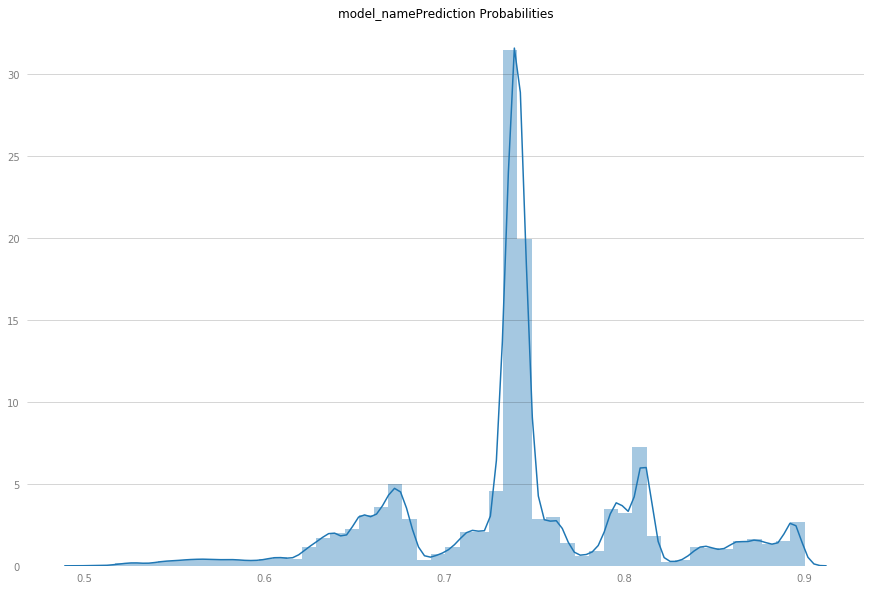



               precision    recall  f1-score   support

      0-Pass       0.74      1.00      0.85     38490
      1-Fail       1.00      0.00      0.00     13426

   micro avg       0.74      0.74      0.74     51916
   macro avg       0.87      0.50      0.43     51916
weighted avg       0.81      0.74      0.63     51916



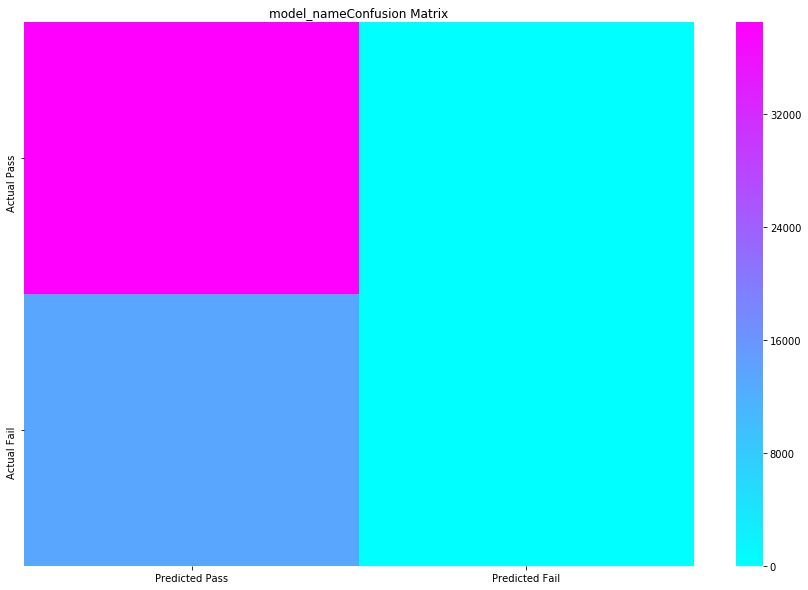

,Predicted Pass,Predicted Fail
Actual Pass,38490,0
Actual Fail,13422,4


In [24]:
model_analysis(random_forest, X_train, y_train, 'model_name')

In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'max_depth':[5, 10],
    'n_estimators': [200, 500]
}

search = RandomizedSearchCV(estimator = RandomForestClassifier(),
                            param_distributions = param_distributions,
                            n_iter=100,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=3,
                            verbose=10,
                            return_train_score=True)
 
search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'max_depth': [5, 10], 'n_estimators': [200, 500]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [30]:
model = search.best_estimator_
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
search.best_score_

0.7178321862786362

# 3. Visualization

In [33]:
!pip install eli5
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 102kB 2.7MB/s 
     |████████████████████████████████| 57.7MB 1.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 225kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


In [34]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='accuracy', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_train.values, y_train)

KeyboardInterrupt: ignored

In [0]:
feature_names = X_train.columns
eli5.show_weights(permuter, top=None, feature_names=feature_names)

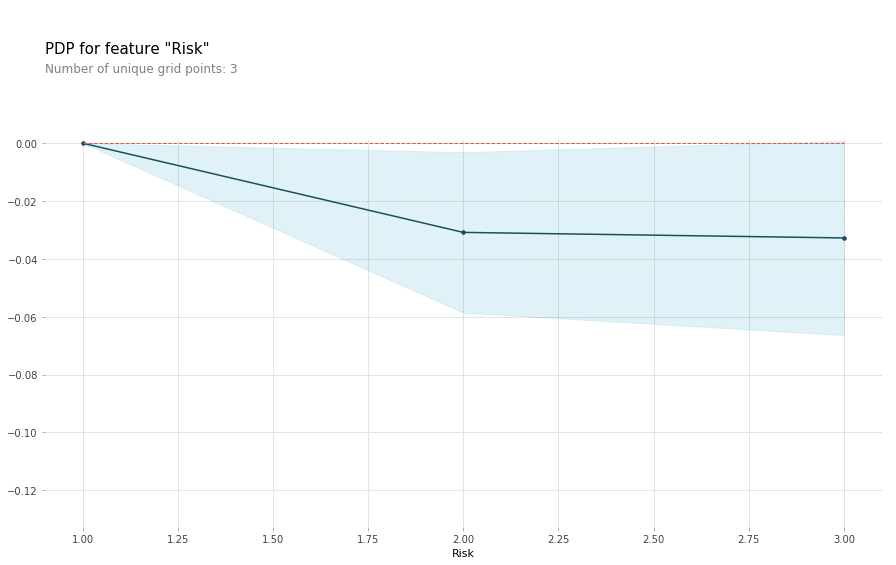

In [36]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Risk'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

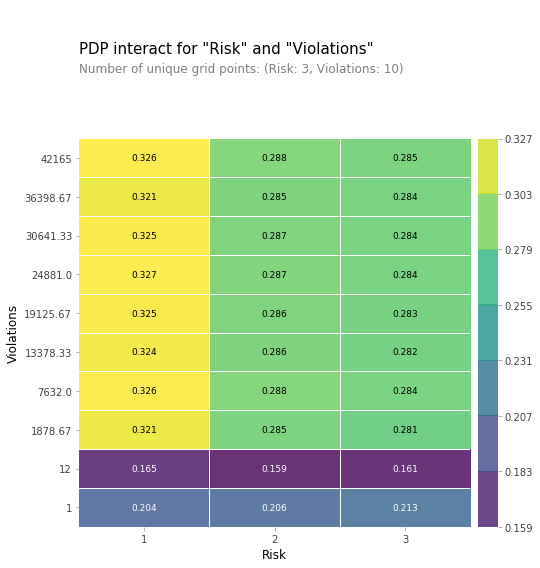

In [38]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot


features_ = ['Risk', 'Violations']

interaction = pdp_interact(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=features_
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features_);

In [39]:
data_for_prediction = X_train.iloc[[50]]
data_for_prediction

,Inspection ID,Facility Type,Risk,Violations,Latitude,Longitude,Inspection Type_Canvass,Inspection Type_Complaint Re-Inspection,Inspection Type_Canvass Re-Inspection,Inspection Type_License Re-Inspection,Inspection Type_License,Inspection Type_Complaint,Inspection Type_Short Form Complaint,Inspection Type_Special Events (Festivals),Inspection Type_Consultation,Inspection Type_Task Force Liquor 1475,Inspection Type_Tag Removal,Inspection Type_Complaint-Fire,Inspection Type_License-Task Force,Inspection Type_Suspected Food Poisoning Re-inspection,Inspection Type_Out of Business,Inspection Type_Complaint-Fire Re-inspection,Inspection Type_TASK FORCE LIQUOR 1470,Inspection Type_Suspected Food Poisoning,Inspection Type_Recent Inspection,Inspection Type_NO ENTRY,Inspection Type_Short Form Fire-Complaint,Inspection Type_KIDS CAFE,Inspection Type_No Entry,Inspection Type_no entry,Inspection Type_Pre-License Consultation,Inspection Type_Package Liquor 1474,Inspection Type_TASK FORCE LIQUOR (1481),Inspection Type_Illegal Operation,Inspection Type_LICENSE RENEWAL FOR DAYCARE,Inspection Type_CANVASS SPECIAL EVENTS,Inspection Type_CHANGED COURT DATE,Inspection Type_TAVERN 1470,Inspection Type_Non-Inspection,Inspection Type_TWO PEOPLE ATE AND GOT SICK.,Inspection Type_Not Ready,Inspection Type_CLOSE-UP/COMPLAINT REINSPECTION,Inspection Type_SMOKING COMPLAINT,Inspection Type_LICENSE WRONG ADDRESS,Inspection Type_OUT OF BUSINESS,Inspection Type_CANVASS/SPECIAL EVENT,Inspection Type_RECALL INSPECTION,Inspection Type_POSSIBLE FBI,Inspection Type_License consultation,Inspection Type_SPECIAL TASK FORCE,Inspection Type_SFP/Complaint,Inspection Type_LICENSE DAYCARE 1586,Inspection Type_license,Inspection Type_LICENSE REQUEST,Inspection Type_ADDENDUM,Inspection Type_SFP/COMPLAINT,Inspection Type_REINSPECTION OF 48 HOUR NOTICE
50,521901,1,3,12,41.951051,-87.708085,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

AssertionError: ignored

# 4. Gradient Descent

- What does Gradient Descent seek to minimize?

  - the output for a given input to a function

- What is the "Learning Rate" and what is its function?

  - The distance of each step